# Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline

# Import our raw data into a Pandas Dataframe
# low_memory is just to make the 'mixed types' warning go away.
df1 = pd.read_csv('delta_public_87_99.csv', low_memory=False)
df2 = pd.read_csv('delta_public_00_12.csv', low_memory=False)

# Combine the 87-99 data with the 00-12 data into one frame
frames = [df1, df2]
data = pd.concat(frames)


## Data Exploration

In [2]:
# Get number of observations and number of attributes
print data.shape

(215613, 974)


In [3]:
# Get some summary statistics of our target variable
display(data['total_enrollment'].describe())

count    153168.000000
mean       2809.486148
std        7540.511589
min           0.000000
25%         101.000000
50%         481.000000
75%        2344.000000
max      380232.000000
Name: total_enrollment, dtype: float64

In [4]:
# Drop rows with missing enrollment data
data = data[np.isfinite(data['total_enrollment'])]
data.shape

(153168, 974)

,total_enrollment,totalcompletions,assets06,loan_num,local03
count,153168.000000,139169.000000,6.296600e+04,68345.000000,1.600400e+04
mean,2809.486148,593.236129,1.798120e+08,240.711777,9.618038e+06
std,7540.511589,1456.242667,1.134594e+09,747.546118,1.792646e+07
min,0.000000,0.000000,-3.721908e+06,0.000000,6.000000e+00
25%,101.000000,56.000000,1.868081e+06,15.000000,1.108431e+06
50%,481.000000,189.000000,1.912804e+07,82.000000,3.666558e+06
75%,2344.000000,544.000000,8.559663e+07,262.000000,1.048297e+07
max,380232.000000,92011.000000,6.410306e+10,106840.000000,3.266246e+08


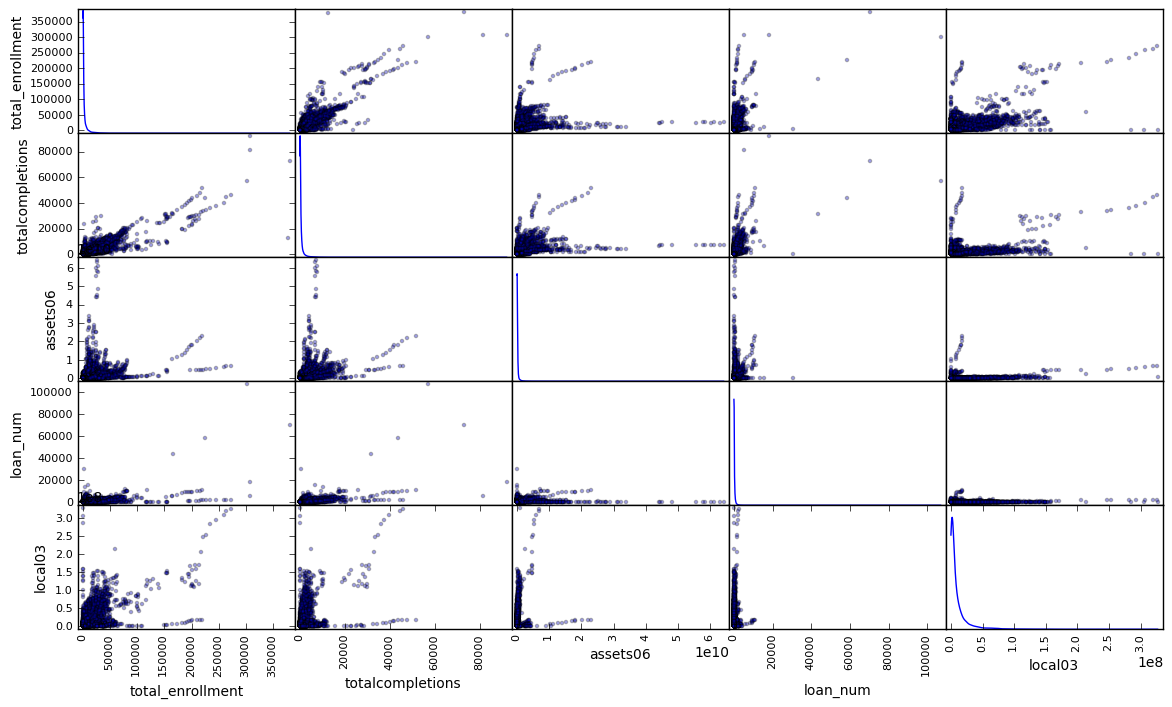

In [5]:
# Produce a scatter matrix for several sample pairs of features in the data
sample_cols = ['total_enrollment', 'totalcompletions', 'assets06', 'loan_num', 'local03']
display(data[sample_cols].describe())
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');


## Data Preprocessing

In [6]:
# Drop non-numbers, not useful for us
data = data.select_dtypes(include=['float64', 'int64'])

# Force the numeric cells to be proper numbers
data = data.convert_objects(convert_numeric=True)

In [7]:
# Lets drop the outliers, at least of the enrollment!

# Calculate Q1 (25th percentile of the data) for the given feature
Q1 = np.percentile(data['total_enrollment'], 25)
    
# Calculate Q3 (75th percentile of the data) for the given feature
Q3 = np.percentile(data['total_enrollment'], 75)
    
# Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
step = 1.5*(Q3-Q1)
    
# For removing outliers in total_enrollment
data = data[((data['total_enrollment'] >= Q1 - step) & (data['total_enrollment'] <= Q3 + step))]

In [8]:
# Handle the missing values
# Impute missing data via interpolation
data = data.interpolate()

# Use mean for remaining missing data
data = data.fillna(data.mean())

display(data[sample_cols].describe())

,total_enrollment,totalcompletions,assets06,loan_num,local03
count,133505.000000,133505.000000,1.335050e+05,133505.000000,1.335050e+05
mean,934.068045,242.364748,5.364570e+07,145.403750,3.376199e+06
std,1279.206152,342.843120,1.546435e+08,204.829182,8.776171e+06
min,0.000000,0.000000,-3.721908e+06,0.000000,6.000000e+00
25%,82.000000,43.000000,2.389521e+06,64.000000,2.979749e+05
50%,314.000000,129.000000,1.338364e+07,145.403750,1.490397e+06
75%,1302.000000,324.000000,4.600569e+07,145.403750,3.920947e+06
max,5708.000000,23432.000000,6.267264e+09,30478.000000,3.266246e+08


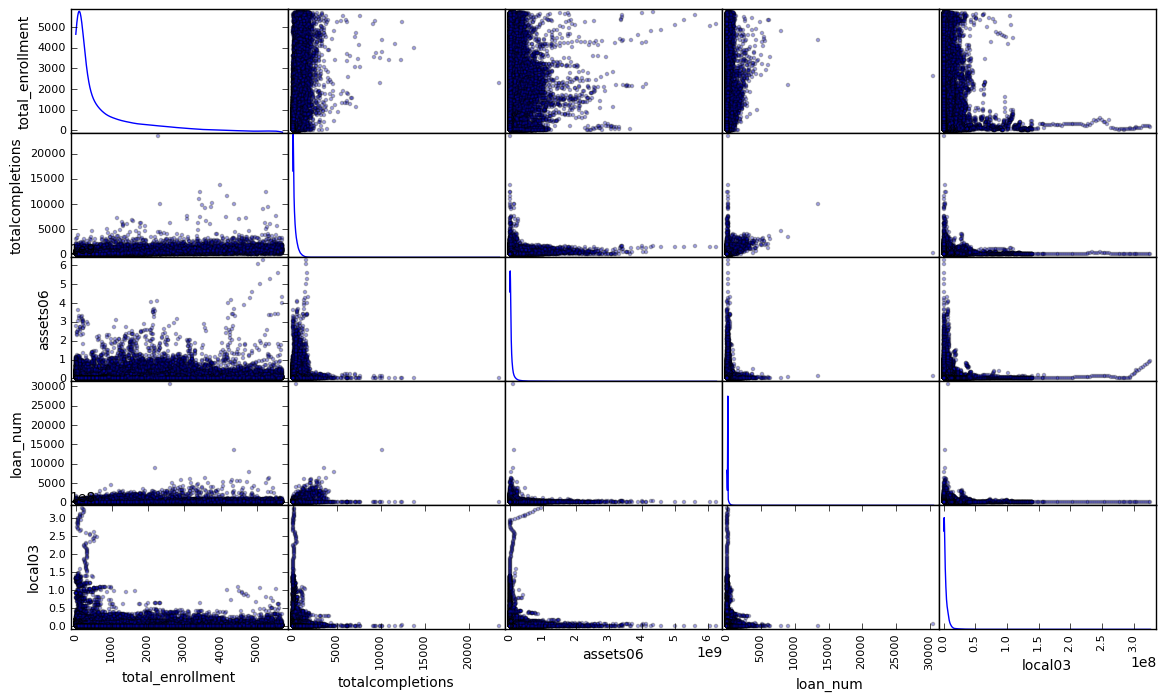

In [9]:
# Produce a scatter matrix for several sample pairs of features in the data
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [10]:
# We will need these values for normalizing and transforming back from normalizing
enroll_min = data['total_enrollment'].min()
enroll_max = data['total_enrollment'].max()
enlarge_factor = 10000

# Use this to transform a scaled enrollment value back to the original scale
def original_scale_transform(value):
    new_data = np.exp(value)
    
    new_data = new_data / enlarge_factor
    
    new_data = new_data * (enroll_max - enroll_min) + enroll_min
    
    return new_data

In [11]:
# min/max scale, and multiply by 10k to avoid tiny numbers.  Then take the log to center.
data = 10000*(data - data.min()) / (data.max() - data.min())
data = np.log(data)

# the log(0) values were turned into -inf, we want those as zero for normalization
data = data.replace(-np.inf, 0)

display(data[sample_cols].describe())

,total_enrollment,totalcompletions,assets06,loan_num,local03
count,133505.000000,133505.000000,133505.000000,133505.000000,133505.000000
mean,6.260940,3.839615,3.466537,3.275796,3.237784
std,1.734869,1.436288,1.314100,1.395685,2.269238
min,0.000000,-2.460955,0.000000,-3.376183,-9.295370
25%,4.967436,2.909683,2.276812,3.044463,2.210763
50%,6.310109,4.008295,3.306054,3.865094,3.820567
75%,7.732373,4.929226,4.373211,3.865094,4.787860
max,9.210340,9.210340,9.210340,9.210340,9.210340


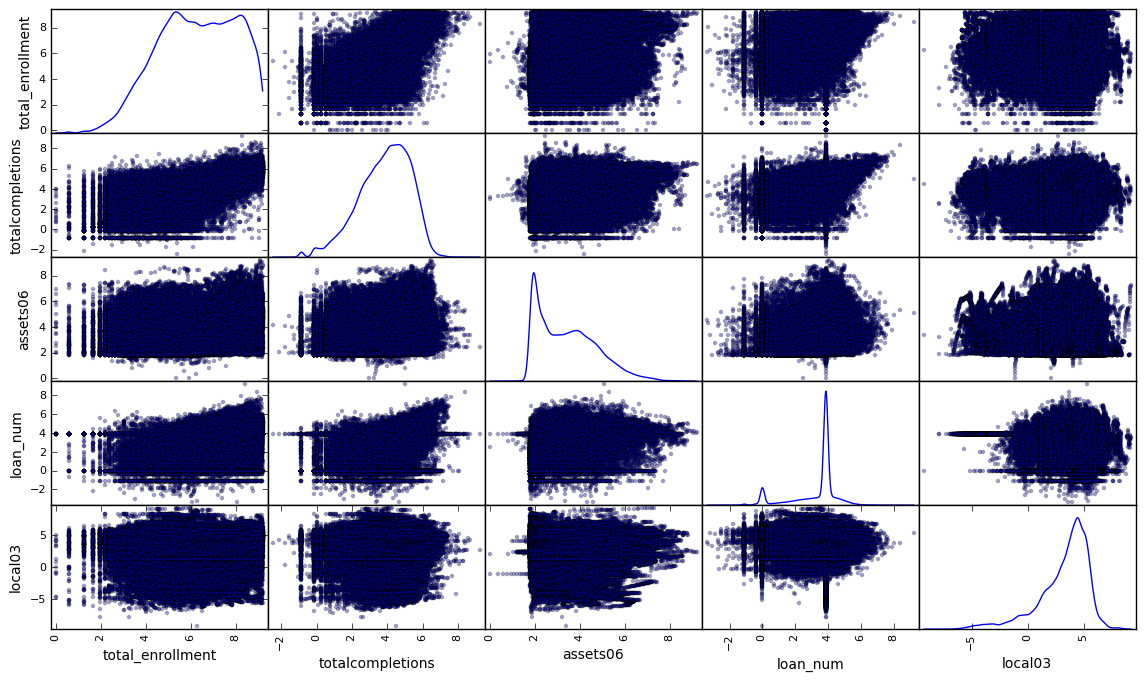

In [12]:
# Produce a scatter matrix for several normalized sample pairs of features in the data
pd.scatter_matrix(data[sample_cols], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [13]:
# Isolate Target Variable
enrollment = data['total_enrollment']
features = data.drop('total_enrollment', axis = 1)

In [14]:
from sklearn.cross_validation import train_test_split

# Split to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(features, enrollment, test_size=0.2, random_state=42)

## Baseline and Candidate Models

In [15]:
# Baseline Model
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

# Use admission's count, plus the retention data in a linear regression
reg.fit(X_train[['admitcount', 'ptretention_rate', 'ftretention_rate']], y_train)

from sklearn.metrics import mean_squared_error

baseline_pred = reg.predict(X_test[['admitcount', 'ptretention_rate', 'ftretention_rate']])

# Turns out this is a terrible way to predict.  Hopefully we can do better than that.
print "Benchmark Model, Training Mean Squared Error:", mean_squared_error(y_train, reg.predict(X_train[['admitcount', 'ptretention_rate', 'ftretention_rate']]))
print "Benchmark Model, Testing Mean Squared Error:", mean_squared_error(y_test, baseline_pred)

Benchmark Model, Training Mean Squared Error: 2.92670403437
Benchmark Model, Testing Mean Squared Error: 2.9127528257


In [16]:
from sklearn.decomposition import FastICA

# n_components = 17, because that's the max number of features with
# the number of observations we have, considering the curse of
# dimensionality
ica = FastICA(n_components=17, random_state=42)
ica.fit(X_train)

# Our new 17 features
X_train_ica = ica.transform(X_train)
X_test_ica = ica.transform(X_test)

In [17]:
# Candidate Model 1, Linear Regression
# Same technique as the baseline, but uses our ICA features instead of the three preset

cm1_reg = LinearRegression()

# Make sure to use the ICA features
cm1_reg.fit(X_train_ica, y_train)

# Generate predictions
cm1_pred = cm1_reg.predict(X_test_ica)

# Report Results
print "Candidate Model 1, Training Mean Squared Error:", mean_squared_error(y_train, cm1_reg.predict(X_train_ica))
print "Candidate Model 1, Testing Mean Squared Error:", mean_squared_error(y_test, cm1_pred)

Candidate Model 1, Training Mean Squared Error: 0.572164100866
Candidate Model 1, Testing Mean Squared Error: 0.568313314229


In [18]:
# Candidate Model 2, Support Vector Regressor
# Notice: This model runs significantly slower than the baseline and candidate model 1 and 3
from sklearn.svm import SVR

cm2_reg = SVR()

# Make sure to use the ICA features
cm2_reg.fit(X_train_ica, y_train)

# Generate predictions
cm2_pred = cm2_reg.predict(X_test_ica)

# Report Results
print "Candidate Model 2, Training Mean Squared Error:", mean_squared_error(y_train, cm2_reg.predict(X_train_ica))
print "Candidate Model 2, Testing Mean Squared Error:", mean_squared_error(y_test, cm2_pred)

Candidate Model 2, Training Mean Squared Error: 2.73706191612
Candidate Model 2, Testing Mean Squared Error: 2.71240878953


In [19]:
# Candidate Model 3, Random Forest Regressor (ensemble method)
from sklearn.ensemble import RandomForestRegressor

cm3_reg = RandomForestRegressor(random_state=42)

# Make sure to use the ICA features
cm3_reg.fit(X_train_ica, y_train)

# Generate predictions
cm3_pred = cm3_reg.predict(X_test_ica)

# Report Results
print "Candidate Model 3, Training Mean Squared Error:", mean_squared_error(y_train, cm3_reg.predict(X_train_ica))
print "Candidate Model 3, Testing Mean Squared Error:", mean_squared_error(y_test, cm3_pred)

Candidate Model 3, Training Mean Squared Error: 0.0683715696409
Candidate Model 3, Testing Mean Squared Error: 0.357933570385


## Grid Search Parameters for Final Model

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Random Forest Regressor patameters
parameters = {
    'n_estimators': [5, 10, 20, 40], # Number of Trees in the Forest
    'max_features': ["auto", "sqrt", "log2"], # Number of features to examine
}

# Initialize the classifier
fin_reg = RandomForestRegressor(random_state=42)

# Make an mean squared error scoring function using 'make_scorer' 
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search on the model using the mse_scorer as the scoring method
grid_obj = GridSearchCV(fin_reg, parameters, scoring=mse_scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train_ica, y_train)

# Get the estimator
fin_reg = grid_obj.best_estimator_

# Report the final mean squared error for training and testing after parameter tuning
print "Tuned model has a training MSE of: ", mean_squared_error(y_train, fin_reg.predict(X_train_ica))
print "Tuned model has a testing MSE score of:", mean_squared_error(y_test, fin_reg.predict(X_test_ica))

Tuned model has a training MSE of:  0.0483963918496
Tuned model has a testing MSE score of: 0.317403771462


## Freeform Visualizations
Considering the high number of dimensions, and the large number of data points, getting a decent visual can be difficult.  Best I could come up with is to find the ICA result that has the biggest impact, and use that as the 'X' axis, with total_enrollment as the 'y' axis.  We can see how actual and predicted observations are pretty close to one another.

In [22]:
# Find most important feature from our ICA in our Model
print fin_reg.feature_importances_

# Also find best parameters of our tuned model
print grid_obj.best_params_

[ 0.02581369  0.01805042  0.03594275  0.06880644  0.00772391  0.43530663
  0.0798422   0.08921014  0.08288907  0.01098869  0.02142842  0.0145342
  0.02285247  0.01760844  0.04156244  0.00868391  0.0187562 ]
{'max_features': 'auto', 'n_estimators': 40}


<Container object of 968 artists>

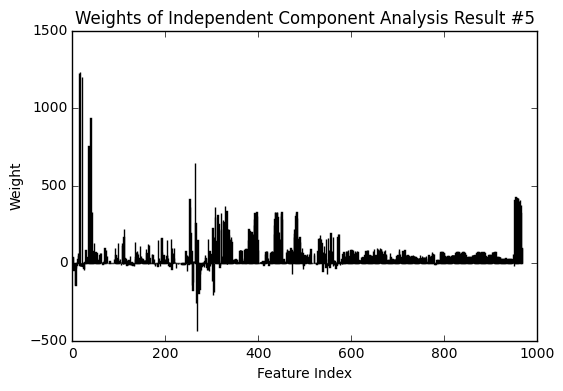

In [23]:
# Trying to figure out what exactly ICA#5 is, can be kind of a pain.  Here's a bar chart of the weights
plt.title('Weights of Independent Component Analysis Result #5')
plt.xlabel('Feature Index')
plt.ylabel('Weight')
plt.bar(range(len(ica.mixing_[:,5])), ica.mixing_[:,5], color='cyan')

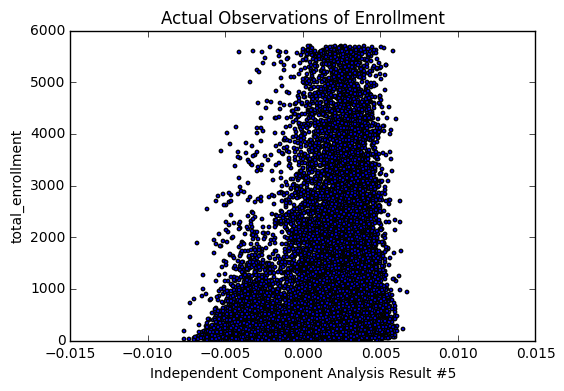

In [24]:
plt.ylabel('total_enrollment')
plt.xlabel('Independent Component Analysis Result #5')
plt.ylim(ymin=0, ymax=6000)
plt.title('Actual Observations of Enrollment')
plt.scatter(X_test_ica[:,5], original_scale_transform(y_test), s=6)

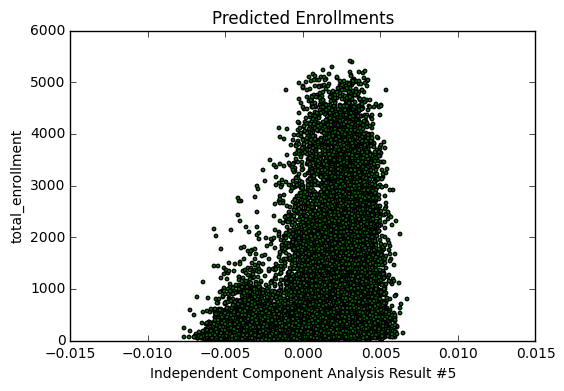

In [25]:
plt.ylabel('total_enrollment')
plt.xlabel('Independent Component Analysis Result #5')
plt.title('Predicted Enrollments')
plt.ylim(ymin=0, ymax=6000)
plt.scatter(X_test_ica[:,5], original_scale_transform(fin_reg.predict(X_test_ica)), c='g', s=6)